<a href="https://colab.research.google.com/github/eugeneyan/visualizing-finetunes/blob/main/3_ft_usb_then_fib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sun Nov  5 17:23:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%pip install -q transformers accelerate bitsandbytes datasets peft watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.9 MB/s eta 0:00:00


In [ ]:
%load_ext watermark
%watermark --conda -p torch,transformers,peft,datasets,sklearn

torch       : 2.1.0+cu118
transformers: 4.35.0
peft        : 0.6.0
datasets    : 2.14.6
sklearn     : 1.2.2

conda environment: n/a



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import transformers
import time
import logging
import warnings
import matplotlib.pyplot as plt

from collections import Counter
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
from transformers import (
    Trainer,
    BartForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    IntervalStrategy,
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
from typing import Dict, Optional, List
from sklearn.metrics import (average_precision_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.exceptions import UndefinedMetricWarning

In [ ]:
# Set up logger
logger = logging.getLogger('3-ft-usb-then-fib')
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True
)

logger.info('Running notebook to finetune USB followed by FIB')

2023-11-05 17:24:12 - INFO - Running notebook to finetune USB followed by FIB


In [ ]:
# Suppress undefined metric warning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.manual_seed(1368)

## Define model and tokenizer
- Note: Entailment = 2, Neutral = 1, Contradiction = 0
- https://huggingface.co/valhalla/distilbart-mnli-12-1

In [ ]:
# Define model
model_id = 'valhalla/distilbart-mnli-12-1'
lora_model_id = 'lora-distilbart-mnli-12-1'

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

## Load FIB data

In [ ]:
# Test loading into dataset
fib_files = {'train': '/content/drive/My Drive/fib-train.csv',
             'val': '/content/drive/My Drive/fib-val.csv'}

fib_ds = load_dataset('csv', data_files=fib_files)
fib_ds = fib_ds.select_columns(['input', 'list_choices', 'label'])
fib_ds = fib_ds.rename_column('input', 'premise').rename_column('list_choices', 'hypothesis')

logger.info(f"Distribution of labels - Train: {Counter(fib_ds['train']['label'])}, Val: {Counter(fib_ds['val']['label'])}")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

2023-11-05 17:24:51 - INFO - Distribution of labels - Train: Counter({0: 400, 2: 400}), Val: Counter({2: 100, 0: 100})


In [ ]:
# Test loading into dataset
usb_files = {'train': '/content/drive/My Drive/usb-train.csv',
             'val': '/content/drive/My Drive/usb-val.csv'}

usb_ds = load_dataset('csv', data_files=usb_files)
usb_ds = usb_ds.select_columns(['source', 'summary_sent', 'label'])
usb_ds = usb_ds.rename_column('source', 'premise').rename_column('summary_sent', 'hypothesis')

logger.info(f"Label distribution - Train: {Counter(usb_ds['train']['label'])}, Val: {Counter(usb_ds['val']['label'])}")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

2023-11-05 17:24:59 - INFO - Label distribution - Train: Counter({2: 2525, 0: 2525}), Val: Counter({2: 1334, 0: 1334})


In [ ]:
# Tokenize data in batch
def tokenize(row):
    return tokenizer(row['premise'], row['hypothesis'], truncation='only_first', padding='max_length', max_length=512)

fib_ds = fib_ds.map(tokenize, batched=True)
usb_ds = usb_ds.map(tokenize, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/5050 [00:00<?, ? examples/s]

Map:   0%|          | 0/2668 [00:00<?, ? examples/s]

In [ ]:
logger.info(f'FIB: {fib_ds["train"][0]["premise"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["hypothesis"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["input_ids"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["attention_mask"]}')

2023-11-05 17:25:11 - INFO - FIB: Vehicles and pedestrians will now embark and disembark the Cowes ferry separately following Maritime and Coastguard Agency (MCA) guidance.
Isle of Wight Council said its new procedures were in response to a resident's complaint.
Councillor Shirley Smart said it would "initially result in a slower service".
Originally passengers and vehicles boarded or disembarked the so called "floating bridge" at the same time.
Ms Smart, who is the executive member for economy and tourism, said the council already had measures in place to control how passengers and vehicles left or embarked the chain ferry "in a safe manner".
However, it was "responding" to the MCA's recommendations "following this complaint".
She added: "This may initially result in a slower service while the measures are introduced and our customers get used to the changes."
The service has been in operation since 1859.
2023-11-05 17:25:11 - INFO - ---------------------------------------------------

In [ ]:
logger.info(f'USB: {usb_ds["train"][0]["premise"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'USB: {usb_ds["train"][0]["hypothesis"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'USB: {usb_ds["train"][0]["input_ids"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'USB: {usb_ds["train"][0]["attention_mask"]}')

2023-11-05 17:25:14 - INFO - USB: Wendy Jane Crewson Crewson was born in Hamilton, Ontario, the daughter of June Doreen (née Thomas) and Robert Binnie Crewson. Also in 2012, Crewson began playing Dr. Dana Kinny in the CTV medical drama "Saving Hope", for which she received Canadian Screen Award for Best Supporting Actress in a Drama Program or Series in 2013.
2023-11-05 17:25:14 - INFO - -------------------------------------------------------------
2023-11-05 17:25:14 - INFO - USB: Wendy Jane Crewson is a Canadian actress.
2023-11-05 17:25:14 - INFO - -------------------------------------------------------------
2023-11-05 17:25:14 - INFO - USB: [0, 771, 1397, 219, 7343, 10493, 1478, 10493, 1478, 21, 2421, 11, 4127, 6, 4170, 6, 5, 1354, 9, 502, 211, 1688, 225, 36, 282, 9703, 1813, 43, 8, 1738, 163, 31854, 10493, 1478, 4, 1578, 11, 1125, 6, 10493, 1478, 880, 816, 925, 4, 11014, 12823, 2855, 11, 5, 230, 2915, 1131, 4149, 22, 104, 13286, 8012, 1297, 13, 61, 79, 829, 1563, 14828, 3683, 13,

## Set up model

In [ ]:
# Define params
LEARNING_RATE=5e-5
BATCH_SIZE=16
R=16
EPOCHS=3
EVAL_STEPS=40
LORA_DROPOUT=0.1
LORA_ALPHA=32
MAX_STEPS=-1

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

In [ ]:
# Load model
model = BartForSequenceClassification.from_pretrained(model_id, quantization_config=bnb_config, device_map='auto', num_labels=3)

2023-11-05 17:25:32 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


In [ ]:
# Configure lora
config = LoraConfig(
    r=R,
    lora_alpha=LORA_ALPHA,  # Keep lora alpha constant (per https://arxiv.org/abs/2305.14314) as it is proportional to learning rate
    target_modules=['k_proj', 'v_proj', 'q_proj', 'out_proj', 'fc1', 'fc2'],
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model.enable_input_require_grads()
model = get_peft_model(model, config)

In [ ]:
# Preprocess only logits to save memory
def preprocess_logits_for_metrics(logits, labels):
    """
    Returns the probability of contradiction (aka factual inconsistency aka hallucination)
    """
    # Exclude dim = 1 on the logits, compute softmax, and get prob of the 0 label (i.e., contradiction)
    probs = F.softmax(logits[0][:, [0, 2]], dim=1)[:, 0]
    return probs

# Compute multiple metrics at once
def compute_metrics(eval_pred: transformers.EvalPrediction) -> Dict[str, float]:
    labels = eval_pred.label_ids
    probs = eval_pred.predictions
    probs_thresholded = np.where(probs >= 0.60, 1, 0)  # Assign score > 0.8 = 1 (aka contradiction)

    # Update labels so 2 (entailment) is now 0, and 0 (contradiction) is now 1 because we want to focus on the latter
    labels = np.where(labels==2, 0, 1)  # If label = 2, return 0, else, return 1

    # Compute metrics
    pr_auc = average_precision_score(labels, probs)
    roc_auc = roc_auc_score(labels, probs)
    recall = recall_score(labels, probs_thresholded)
    precision = precision_score(labels, probs_thresholded)

    return {'prauc': pr_auc, 'rocauc': roc_auc, 'recall': recall, 'precision': precision}

In [ ]:
# Set training arguments
training_args = transformers.TrainingArguments(
    output_dir='/content/drive/My Drive/Colab Notebooks',
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Bigger batch size for eval
    num_train_epochs=EPOCHS,
    evaluation_strategy='steps',
    eval_steps=EVAL_STEPS,
    gradient_accumulation_steps=4,
    bf16=False,
    max_steps=MAX_STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    metric_for_best_model='prauc',
    greater_is_better=True,
    load_best_model_at_end=True,
)

## Set up trainer to finetune on USB data
- Note: label = 0 is after edit/factual consistency; label = 1 is before edit/factual inconsistency
- https://github.com/kukrishna/usb/blob/master/dataset_creators/usb_fac.py#L83

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=usb_ds['train'],
    eval_dataset=usb_ds['val'],
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

## Check evals before finetuning

In [ ]:
def visualize_preds(y, y_pred, model_name):
    df = pd.DataFrame({'label': y, 'pred_proba': y_pred})

    # Compute ROCAUC metrics
    rocauc = roc_auc_score(df['label'], df['pred_proba'])
    fpr, tpr, thresholds = roc_curve(df['label'], df['pred_proba'])
    baseline = np.sum(df['label']) / len(df)

    # Compute PRAUC metrics
    prauc = average_precision_score(df['label'], df['pred_proba'])
    prec, rec, thresholds = precision_recall_curve(df['label'], df['pred_proba'])

    # Split into consistent and inconsistent for prob distribution
    inconsistent = df[df['label'] == 1].reset_index(drop=True)
    consistent = df[df['label'] == 0].reset_index(drop=True)

    # Set up plots
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
    title_font_size = 10
    fig.suptitle(f'{model_name}', fontsize=title_font_size+2, y=1)

    # Plot ROC
    ax0.grid()
    ax0.plot(fpr, tpr, label='ROC')
    ax0.plot([0, 1], [0, 1], label='Random chance', linestyle='--', color='red')
    ax0.set_xlabel('False positive rate')
    ax0.set_ylabel('True positive rate')
    ax0.set_title(f'ROC AUC = {rocauc:.2f}', fontsize=title_font_size)
    ax0.legend()

    # Plot PRAUC
    ax1.grid()
    ax1.plot(rec, prec, label='PRAUC')
    ax1.axhline(y=baseline, label='Baseline', linestyle='--', color='red')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_xlim((-0.1, 1.1))
    ax1.set_ylim((-0.1, 1.1))
    ax1.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

    # Plot prob distribution
    ax2.grid()
    ax2.hist(inconsistent['pred_proba'], color='red', alpha=0.5, density=True, label='Inconsistent', bins=20)
    ax2.hist(consistent['pred_proba'], color='green', alpha=0.5, density=True, label='Consistent', bins=20)
    ax2.set_xlabel('Prob of inconsistent')
    ax2.set_ylabel('Density')
    ax2.set_title('Prob dist for consistent vs. inconsistent', fontsize=title_font_size)
    ax2.legend()

    plt.show()


def compute_metrics_per_threshold(y, y_pred, thresholds=[0.95, 0.90, 0.95, 0.80, 0.75, 0.70, 0.65, 0.60]):
    for threshold in thresholds:
        preds = (y_pred >= threshold).astype(int)

        recall = recall_score(y, preds)
        precision = precision_score(y, preds)
        logger.info(f'Threshold: {threshold:.2f} - Recall: {recall:.2f}, Precision: {precision:.2f}')

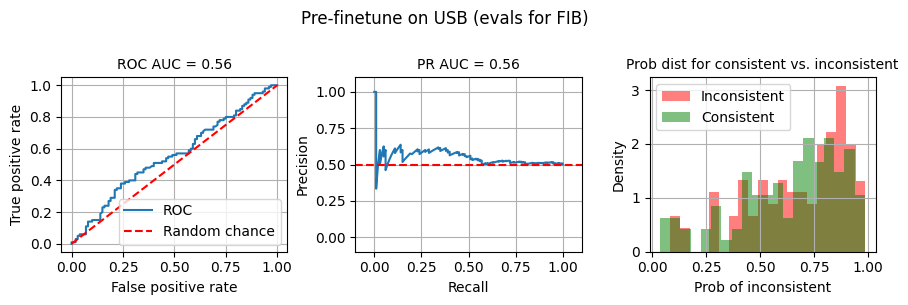

2023-11-05 17:26:02 - INFO - Threshold: 0.95 - Recall: 0.05, Precision: 0.62
2023-11-05 17:26:02 - INFO - Threshold: 0.90 - Recall: 0.15, Precision: 0.58
2023-11-05 17:26:02 - INFO - Threshold: 0.95 - Recall: 0.05, Precision: 0.62
2023-11-05 17:26:02 - INFO - Threshold: 0.80 - Recall: 0.40, Precision: 0.57
2023-11-05 17:26:02 - INFO - Threshold: 0.75 - Recall: 0.49, Precision: 0.56
2023-11-05 17:26:02 - INFO - Threshold: 0.70 - Recall: 0.55, Precision: 0.53
2023-11-05 17:26:02 - INFO - Threshold: 0.65 - Recall: 0.58, Precision: 0.50
2023-11-05 17:26:02 - INFO - Threshold: 0.60 - Recall: 0.66, Precision: 0.52


In [ ]:
# Get predictions
fib_val_preds = trainer.predict(fib_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
fib_val_labels = np.array(fib_ds['val']['label'])
fib_val_labels = np.where(fib_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(fib_val_labels, fib_val_preds, 'Pre-finetune on USB (evals for FIB)')
compute_metrics_per_threshold(fib_val_labels, fib_val_preds)

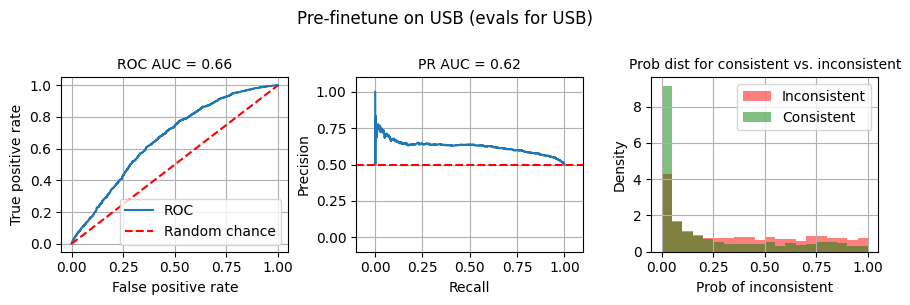

2023-11-05 17:27:06 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.72
2023-11-05 17:27:06 - INFO - Threshold: 0.90 - Recall: 0.07, Precision: 0.70
2023-11-05 17:27:06 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.72
2023-11-05 17:27:06 - INFO - Threshold: 0.80 - Recall: 0.15, Precision: 0.65
2023-11-05 17:27:06 - INFO - Threshold: 0.75 - Recall: 0.19, Precision: 0.64
2023-11-05 17:27:06 - INFO - Threshold: 0.70 - Recall: 0.23, Precision: 0.65
2023-11-05 17:27:06 - INFO - Threshold: 0.65 - Recall: 0.26, Precision: 0.64
2023-11-05 17:27:06 - INFO - Threshold: 0.60 - Recall: 0.30, Precision: 0.63


In [ ]:
# Get predictions
usb_val_preds = trainer.predict(usb_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
usb_val_labels = np.array(usb_ds['val']['label'])
usb_val_labels = np.where(usb_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(usb_val_labels, usb_val_preds, 'Pre-finetune on USB (evals for USB)')
compute_metrics_per_threshold(usb_val_labels, usb_val_preds)

## Start finetuning

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Prauc,Rocauc,Recall,Precision
40,0.938100,0.649902,0.754641,0.762030,0.404048,0.806886
80,0.555500,0.486816,0.863193,0.851666,0.607196,0.860786
120,0.461800,0.430176,0.901443,0.891291,0.674663,0.889328
160,0.395600,0.397461,0.914731,0.906313,0.757121,0.876736
200,0.377300,0.417480,0.919475,0.910300,0.694903,0.916914


TrainOutput(global_step=237, training_loss=0.5182101092761076, metrics={'train_runtime': 1071.5053, 'train_samples_per_second': 14.139, 'train_steps_per_second': 0.221, 'total_flos': 8051069302732800.0, 'train_loss': 0.5182101092761076, 'epoch': 3.0})

## Check evals after finetuning on USB

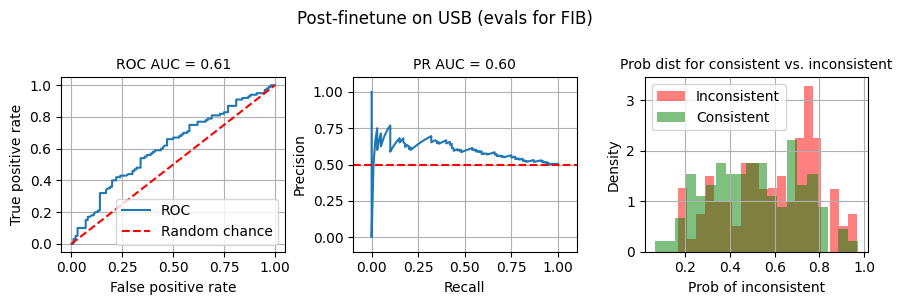

2023-11-05 17:49:16 - INFO - Threshold: 0.95 - Recall: 0.02, Precision: 0.67
2023-11-05 17:49:16 - INFO - Threshold: 0.90 - Recall: 0.04, Precision: 0.67
2023-11-05 17:49:16 - INFO - Threshold: 0.95 - Recall: 0.02, Precision: 0.67
2023-11-05 17:49:16 - INFO - Threshold: 0.80 - Recall: 0.10, Precision: 0.59
2023-11-05 17:49:16 - INFO - Threshold: 0.75 - Recall: 0.22, Precision: 0.61
2023-11-05 17:49:16 - INFO - Threshold: 0.70 - Recall: 0.40, Precision: 0.67
2023-11-05 17:49:16 - INFO - Threshold: 0.65 - Recall: 0.45, Precision: 0.60
2023-11-05 17:49:16 - INFO - Threshold: 0.60 - Recall: 0.54, Precision: 0.61


In [ ]:
# Get predictions
fib_val_preds = trainer.predict(fib_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
fib_val_labels = np.array(fib_ds['val']['label'])
fib_val_labels = np.where(fib_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(fib_val_labels, fib_val_preds, 'Post-finetune on USB (evals for FIB)')
compute_metrics_per_threshold(fib_val_labels, fib_val_preds)

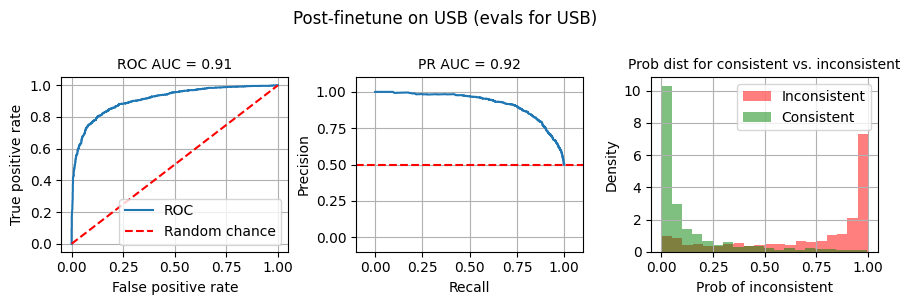

2023-11-05 17:50:19 - INFO - Threshold: 0.95 - Recall: 0.36, Precision: 0.98
2023-11-05 17:50:19 - INFO - Threshold: 0.90 - Recall: 0.47, Precision: 0.97
2023-11-05 17:50:19 - INFO - Threshold: 0.95 - Recall: 0.36, Precision: 0.98
2023-11-05 17:50:19 - INFO - Threshold: 0.80 - Recall: 0.58, Precision: 0.95
2023-11-05 17:50:19 - INFO - Threshold: 0.75 - Recall: 0.61, Precision: 0.95
2023-11-05 17:50:20 - INFO - Threshold: 0.70 - Recall: 0.64, Precision: 0.93
2023-11-05 17:50:20 - INFO - Threshold: 0.65 - Recall: 0.67, Precision: 0.93
2023-11-05 17:50:20 - INFO - Threshold: 0.60 - Recall: 0.69, Precision: 0.92


In [ ]:
# Get predictions
usb_val_preds = trainer.predict(usb_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
usb_val_labels = np.array(usb_ds['val']['label'])
usb_val_labels = np.where(usb_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(usb_val_labels, usb_val_preds, 'Post-finetune on USB (evals for USB)')
compute_metrics_per_threshold(usb_val_labels, usb_val_preds)

## Next, set up trainer to finetune on FIB data
- FIB contains one-sentence summaries on CNN/DM & XSUM news articles.
- Note: We exclude the CNN/Daily Mail data is pretty bad.
- https://huggingface.co/datasets/r-three/fib

In [ ]:
# Define params
LEARNING_RATE=5e-5
BATCH_SIZE=16
R=16
EPOCHS=10
EVAL_STEPS=20
LORA_DROPOUT=0.1
LORA_ALPHA=32
MAX_STEPS=-1

In [ ]:
# Set training arguments
training_args = transformers.TrainingArguments(
    output_dir='/content/drive/My Drive/Colab Notebooks',
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Bigger batch size for eval
    num_train_epochs=EPOCHS,
    evaluation_strategy='steps',
    eval_steps=EVAL_STEPS,  # Update eval steps to reduce time spent on evals
    gradient_accumulation_steps=4,
    bf16=False,
    max_steps=MAX_STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    metric_for_best_model='prauc',
    greater_is_better=True,
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=fib_ds['train'],
    eval_dataset=fib_ds['val'],
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Prauc,Rocauc,Recall,Precision
20,0.671500,0.620605,0.709733,0.718350,0.420000,0.763636
40,0.575800,0.553711,0.787482,0.787800,0.550000,0.797101
60,0.501800,0.521484,0.827591,0.820200,0.630000,0.777778
80,0.426100,0.517578,0.843381,0.831900,0.650000,0.802469
100,0.429700,0.504883,0.854049,0.842000,0.670000,0.788235
120,0.395700,0.506836,0.854718,0.842000,0.640000,0.810127


TrainOutput(global_step=120, training_loss=0.5000930786132812, metrics={'train_runtime': 419.5633, 'train_samples_per_second': 19.067, 'train_steps_per_second': 0.286, 'total_flos': 4081334141583360.0, 'train_loss': 0.5000930786132812, 'epoch': 9.6})

## Check evals after finetuning on USB followed by FIB

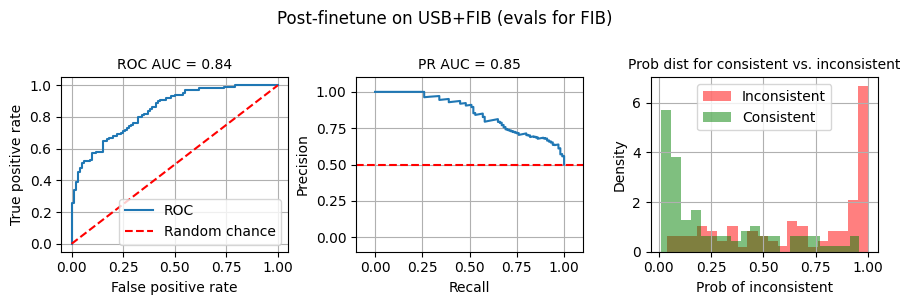

2023-11-05 17:58:21 - INFO - Threshold: 0.95 - Recall: 0.32, Precision: 0.97
2023-11-05 17:58:21 - INFO - Threshold: 0.90 - Recall: 0.42, Precision: 0.93
2023-11-05 17:58:21 - INFO - Threshold: 0.95 - Recall: 0.32, Precision: 0.97
2023-11-05 17:58:21 - INFO - Threshold: 0.80 - Recall: 0.50, Precision: 0.91
2023-11-05 17:58:21 - INFO - Threshold: 0.75 - Recall: 0.52, Precision: 0.87
2023-11-05 17:58:21 - INFO - Threshold: 0.70 - Recall: 0.55, Precision: 0.85
2023-11-05 17:58:21 - INFO - Threshold: 0.65 - Recall: 0.58, Precision: 0.82
2023-11-05 17:58:21 - INFO - Threshold: 0.60 - Recall: 0.64, Precision: 0.81


In [ ]:
# Get predictions
fib_val_preds = trainer.predict(fib_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
fib_val_labels = np.array(fib_ds['val']['label'])
fib_val_labels = np.where(fib_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(fib_val_labels, fib_val_preds, 'Post-finetune on USB+FIB (evals for FIB)')
compute_metrics_per_threshold(fib_val_labels, fib_val_preds)

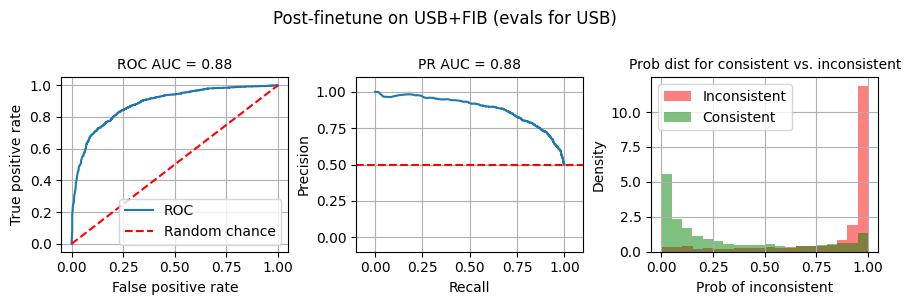

2023-11-05 17:59:22 - INFO - Threshold: 0.95 - Recall: 0.59, Precision: 0.90
2023-11-05 17:59:22 - INFO - Threshold: 0.90 - Recall: 0.69, Precision: 0.88
2023-11-05 17:59:22 - INFO - Threshold: 0.95 - Recall: 0.59, Precision: 0.90
2023-11-05 17:59:22 - INFO - Threshold: 0.80 - Recall: 0.75, Precision: 0.83
2023-11-05 17:59:22 - INFO - Threshold: 0.75 - Recall: 0.77, Precision: 0.81
2023-11-05 17:59:22 - INFO - Threshold: 0.70 - Recall: 0.79, Precision: 0.80
2023-11-05 17:59:22 - INFO - Threshold: 0.65 - Recall: 0.82, Precision: 0.79
2023-11-05 17:59:22 - INFO - Threshold: 0.60 - Recall: 0.83, Precision: 0.78


In [ ]:
# Get predictions
usb_val_preds = trainer.predict(usb_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
usb_val_labels = np.array(usb_ds['val']['label'])
usb_val_labels = np.where(usb_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

visualize_preds(usb_val_labels, usb_val_preds, 'Post-finetune on USB+FIB (evals for USB)')
compute_metrics_per_threshold(usb_val_labels, usb_val_preds)